##STGCN Model for Next-day Solar Energy Production Forecasting
This notebook reads data (train and test) created in the 1_data_preparation.ipynb notebook and proceeds to enable training ST-GCN model variants for next-day solar energy prediction based on weather parameters

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [ ]:
#Import libraries
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, PGExplainer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import time
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv


Model Parameter and Directory to be set before running


In [ ]:
#Set parameters
epochs = 1
look_back = 30

In [ ]:
# #Uncomment if using Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Model Parameter and Directory to be set before running


In [ ]:
root_dir = '/content/drive/MyDrive/AI_Sustainability/models/'
model = 'stgcn'
model_dir = root_dir + model + '/'
os.makedirs(model_dir, exist_ok=True)

In [ ]:
import tensorflow as tf
# Check for available GPUs and configure TensorFlow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  0


In [ ]:
#Load dataset
train_data = "/content/drive/MyDrive/AI_Sustainability/data/train_data_ensemble_0-agg.csv"
X = pd.read_csv(train_data)
print(X.head())
train_dataset = X[['Date', 'min_dist_node', 'stid', 'tcolc_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0', 'tmp_sfc_0', 'tcdc_eatm_0', 'dswrf_sfc_0',
            'tmax_2m_0', 'tmin_2m_0', 'pwat_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0', 'tmp_sfc_0',
            'uswrf_sfc_0', 'spfh_2m_0', 'ulwrf_sfc_0', 'tmp_2m_0', 'apcp_sfc_0', 'pres_msl_0', 'Daily_Production']]

test_data = "/content/drive/MyDrive/AI_Sustainability/data/test_data_ensemble_0-agg.csv"
X = pd.read_csv(test_data)
test_dataset = X[['Date', 'min_dist_node','stid', 'tcolc_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0', 'tmp_sfc_0', 'tcdc_eatm_0', 'dswrf_sfc_0',
            'tmax_2m_0', 'tmin_2m_0', 'pwat_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0', 'tmp_sfc_0',
            'uswrf_sfc_0', 'spfh_2m_0', 'ulwrf_sfc_0', 'tmp_2m_0', 'apcp_sfc_0', 'pres_msl_0', 'Daily_Production']]

stations = train_dataset['stid'].unique()
print(f"Number of stations: {len(stations)}")

         Date  stid  Daily_Production  \
0  2000-01-01  ACME          11860500   
1  2000-01-02  ACME          11065500   
2  2000-01-03  ACME          11982900   
3  2000-01-04  ACME          13254000   
4  2000-01-05  ACME          12955200   

                                       new_distances  \
0  {(np.float32(33.0), np.float32(257.0)): 501.30...   
1  {(np.float32(33.0), np.float32(257.0)): 501.30...   
2  {(np.float32(33.0), np.float32(257.0)): 501.30...   
3  {(np.float32(33.0), np.float32(257.0)): 501.30...   
4  {(np.float32(33.0), np.float32(257.0)): 501.30...   

                           min_dist_node  \
0  (np.float32(35.0), np.float32(262.0))   
1  (np.float32(35.0), np.float32(262.0))   
2  (np.float32(35.0), np.float32(262.0))   
3  (np.float32(35.0), np.float32(262.0))   
4  (np.float32(35.0), np.float32(262.0))   

                                            join  tcolc_eatm_0  ulwrf_tatm_0  \
0  20000101(np.float32(35.0), np.float32(262.0))      0.001185     257.

In [ ]:
print(train_dataset.shape)
print(test_dataset.shape)

(179046, 22)
(35770, 22)


##Data Preprocessing

This performs interpolation, NaN filling, Station ID Encoding

In [ ]:
def preprocess_data(df):
    """
    Preprocess the dataset

    Parameters:
    -----------
    df : pandas DataFrame
        Raw dataset

    Returns:
    --------
    df : pandas DataFrame
        Processed dataset with additional features
    """
    # Convert date to datetime
    df["Date"] = pd.to_datetime(df["Date"])

    # Sort by station and date
    df = df.sort_values(["stid", "Date"]).reset_index(drop=True)

    # Extract weather features
    weather_features = [col for col in df.columns if col.endswith("_0")]

    # Add temporal features
    df["dayofyear"] = df["Date"].dt.dayofyear
    df["month"] = df["Date"].dt.month
    df["weekday"] = df["Date"].dt.weekday

    # Extract spatial coordinates from min_dist_node
    df["min_dist_node"] = df["min_dist_node"].astype(str)

    def extract_float_tuple(s):
        try:
            return tuple(float(part.replace("np.float32(", "").replace(")", "")) for part in s.strip("()").split(","))
        except:
            return (None, None)

    df[['lat', 'lon']] = df['min_dist_node'].apply(lambda x: pd.Series(extract_float_tuple(str(x))))

    # Fill missing coordinates
    df["lat"] = df["lat"].fillna(method="ffill")
    df["lon"] = df["lon"].fillna(method="ffill")

    # Encode station IDs
    le = LabelEncoder()
    df["stid_encoded"] = le.fit_transform(df["stid"])

    return df, le, weather_features

In [ ]:
# Preprocess training and test data
train_df, station_encoder, weather_features = preprocess_data(train_dataset)
test_df, _, _ = preprocess_data(test_dataset)

<ipython-input-9-92ddff0c987d>:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["lat"] = df["lat"].fillna(method="ffill")
<ipython-input-9-92ddff0c987d>:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["lon"] = df["lon"].fillna(method="ffill")
<ipython-input-9-92ddff0c987d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-9-92ddff0c987d>:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["lat"] = df["lat"].fillna(method

##Temporal Sequence Creation
Sliding window is used to create sequence if "look_back" length

In [ ]:
def create_sequences(data, stations, features, target_col, lookback=7):
    """
    Create sequences with proper lookback window

    Parameters:
    -----------
    data : pandas DataFrame
        Processed dataset
    stations : list
        List of unique station IDs
    features : list
        List of feature columns
    target_col : str
        Target column name
    lookback : int
        Number of previous time steps to use (lookback window)

    Returns:
    --------
    X_sequences : numpy array
        Sequence data with shape (samples, lookback, features)
    y_values : numpy array
        Target values
    dates : numpy array
        Dates corresponding to the target values
    """
    X_sequences = []
    y_values = []
    station_ids = []
    dates = []

    # Additional features to include (non-weather)
    additional_features = ['dayofyear', 'month', 'weekday', 'lat', 'lon', 'stid_encoded']
    all_features = features + additional_features

    for station in stations:
        # Get data for this station
        station_data = data[data['stid'] == station].copy()
        if len(station_data) <= lookback:
            continue

        # Create sequences for this station
        station_features = station_data[all_features].values
        station_target = station_data[target_col].values
        station_dates = station_data['Date'].values

        for i in range(len(station_data) - lookback):
            X_sequences.append(station_features[i:i+lookback])
            y_values.append(station_target[i+lookback])
            station_ids.append(station)
            dates.append(station_dates[i+lookback])

    return np.array(X_sequences), np.array(y_values), np.array(station_ids), np.array(dates)


In [ ]:
# Extract features and targets
features_cols = weather_features
target_col = 'Daily_Production'
station_list = train_df['stid'].unique()

# Create sequences for training data
X_train_seq, y_train, train_stations, train_dates = create_sequences(
    train_df, station_list, features_cols, target_col, lookback=look_back
)

# Create sequences for test data
X_test_seq, y_test, test_stations, test_dates = create_sequences(
    test_df, station_list, features_cols, target_col, lookback=look_back
)

print(f"Training sequences: {X_train_seq.shape}")
print(f"Training targets: {y_train.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print(f"Test targets: {y_test.shape}")

Training sequences: (176106, 30, 30)
Training targets: (176106,)
Test sequences: (32830, 30, 30)
Test targets: (32830,)


##Feature Scaling
Since each weather parameter is different in range and units, column wise scaling is performed

In [ ]:
# Normalize features
scaler_X = StandardScaler()
# Reshape to 2D for scaling
n_samples_train, n_timesteps, n_features = X_train_seq.shape
X_train_reshaped = X_train_seq.reshape(n_samples_train * n_timesteps, n_features)
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
# Reshape back to 3D
X_train_scaled = X_train_scaled.reshape(n_samples_train, n_timesteps, n_features)

# Scale test data using the same scaler
n_samples_test, _, _ = X_test_seq.shape
X_test_reshaped = X_test_seq.reshape(n_samples_test * n_timesteps, n_features)
X_test_scaled = scaler_X.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(n_samples_test, n_timesteps, n_features)

# Scale target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

##Adjaceny Matrix (Graph) Creation

In [ ]:
def create_graph_data(X_seq, y_seq):
    data_list = []
    for i in range(len(X_seq)):
        x = torch.tensor(X_seq[i], dtype=torch.float)  # shape (nodes, features)
        num_nodes = x.size(0)
        edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
        edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # undirected
        data = Data(x=x, edge_index=edge_index, y=torch.tensor([y_seq[i]], dtype=torch.float))
        data_list.append(data)
    return data_list

In [ ]:
train_graphs = create_graph_data(X_train_scaled, y_train_scaled)
test_graphs = create_graph_data(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_graphs, batch_size=128, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=128)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


##Model Definition
ST-GCN Model is defined with various modes tha can be selected by the used and was used for experimentation

In [ ]:
class STGCNModel(nn.Module):
    def __init__(self, num_node_features, hidden_dim):
        super(STGCNModel, self).__init__()
        self.gcn1 = GCNConv(num_node_features, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch, **kwargs):
        x = torch.relu(self.gcn1(x, edge_index))
        x = torch.relu(self.gcn2(x, edge_index))
        # Apply global pooling to get a graph-level representation
        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = self.fc(x)
        return x.squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = STGCNModel(num_node_features=X_train_scaled.shape[2], hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

##Model Training

In [ ]:
model.train()
start = time.time()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    torch.save(model.state_dict(), f'{model_dir}st_gcn_model_epoch_{epoch+1}.pth')
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
end = time.time()
print(f"Time taken: {end - start:.2f} seconds")

Epoch 1, Loss: 56.3167
Time taken: 174.35 seconds


##Model Inference

In [ ]:
model.eval()
preds, actuals = [], []
import time
start_time = time.time()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch.x, batch.edge_index, batch.batch).cpu().numpy()
        preds.extend(pred)
        actuals.extend(batch.y.cpu().numpy())
end = time.time()
print(f"Time taken: {end - start_time:.2f} seconds")
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
preds = scaler_y.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

mae = mean_absolute_error(actuals, preds)
print(f"ST-GCN MAE: {mae:.4f}")

Time taken: 16.31 seconds
ST-GCN MAE: 4130964.7500


In [ ]:
test_dates = pd.to_datetime(test_df['Date'])
print(test_dates)

0       2005-01-01
1       2005-01-02
2       2005-01-03
3       2005-01-04
4       2005-01-05
           ...    
35765   2005-12-27
35766   2005-12-28
35767   2005-12-29
35768   2005-12-30
35769   2005-12-31
Name: Date, Length: 35770, dtype: datetime64[ns]


##Performance Evaluation and Error Analysis

<ipython-input-20-1fab9375745d>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  station_mae = df.groupby('stid').apply(



MAE Report by Station (Top 10 worst performing):
Station ID       MAE  Avg Production  Std Production  Sample Count    Avg Error    Std Error  Max Error  Normalized MAE
      SLAP 5421868.0    1.590725e+07    7.687526e+06           335 5.421868e+06 5.049170e+06 22487888.0        0.340843
      CLAY 4920037.5    1.718610e+07    7.139734e+06           335 4.920037e+06 3.002351e+06 16551246.0        0.286280
      SPEN 4846327.0    1.595492e+07    7.266850e+06           335 4.846327e+06 4.200537e+06 19190710.0        0.303751
      SALL 4687753.5    1.704800e+07    7.336034e+06           335 4.687754e+06 2.744267e+06 15489650.0        0.274974
      PUTN 4686873.5    1.699101e+07    7.015020e+06           335 4.686874e+06 4.165551e+06 18846798.0        0.275844
      KETC 4674283.0    1.752335e+07    7.163523e+06           335 4.674283e+06 3.150880e+06 17134006.0        0.266746
      STIG 4568437.0    1.710749e+07    7.202978e+06           335 4.568437e+06 2.919664e+06 15588262.0       

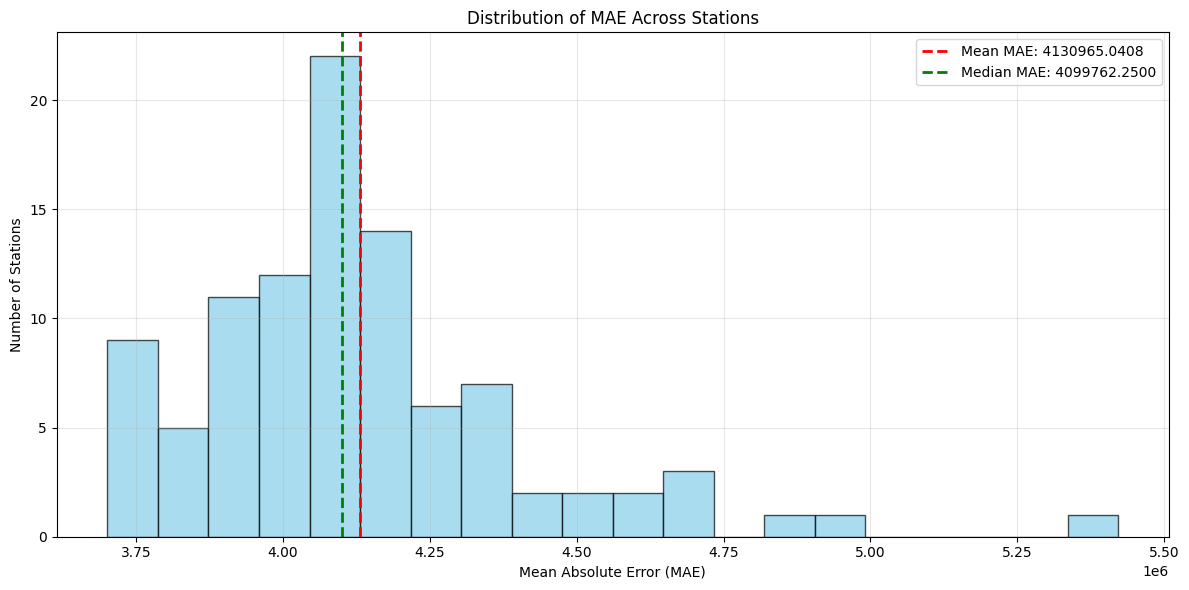

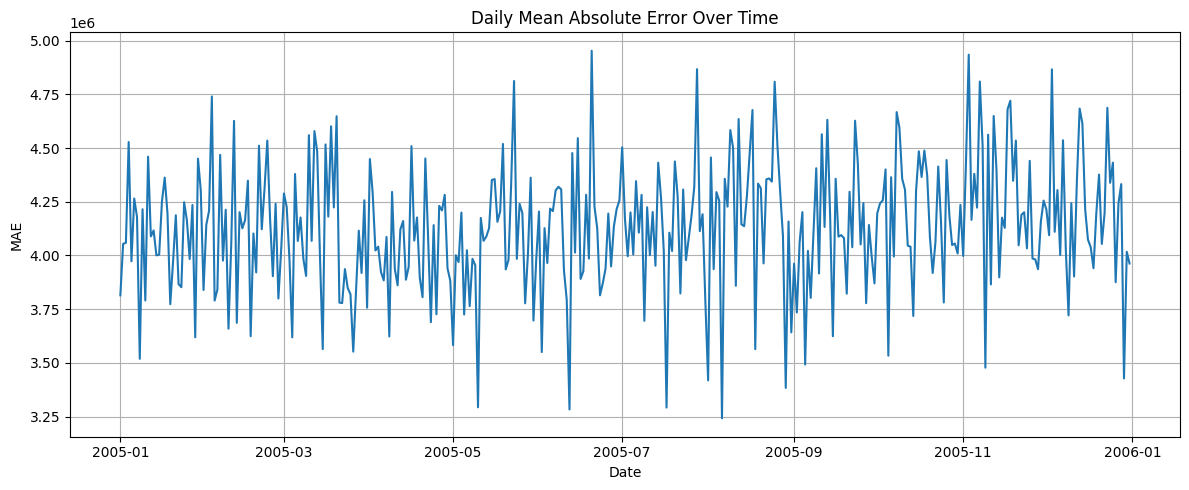

In [ ]:
# Create a dataframe for analysis
df_test = pd.DataFrame(X_test_seq.reshape(X_test_seq.shape[0], -1))
df_test = df_test[[col for col in range(X_test_seq.shape[2]) if col < len(df_test.columns)]]
all_columns = weather_features + ['dayofyear', 'month', 'weekday', 'lat', 'lon', 'stid_encoded']
df_test = df_test[[col for col in range(len(all_columns)) if col < len(df_test.columns)]]

df_test.columns = all_columns
df_test['true'] = y_test
df_test['pred'] = preds.flatten()
df_test['error'] = np.abs(df_test['true'] - df_test['pred'])
df_test['date'] = test_dates
df_test['stid'] = test_stations

# Function to report MAE per station
def report_station_mae(df, top_n=None):
    """
    Calculate and report MAE for each station in the dataset.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'stid', 'true', and 'pred' columns
    top_n : int, optional
        If provided, shows only the top N worst performing stations

    Returns:
    --------
    pandas DataFrame
        DataFrame with stations and their MAE values, sorted by MAE
    """
    # Calculate MAE per station
    station_mae = df.groupby('stid').apply(
        lambda x: mean_absolute_error(x['true'], x['pred'])
    ).reset_index()
    station_mae.columns = ['Station ID', 'MAE']

    # Calculate additional statistics
    station_stats = df.groupby('stid').agg({
        'true': ['mean', 'std', 'count'],
        'error': ['mean', 'std', 'max']
    }).reset_index()

    # Flatten the multi-index columns
    station_stats.columns = ['Station ID', 'Avg Production', 'Std Production',
                            'Sample Count', 'Avg Error', 'Std Error', 'Max Error']

    # Merge the stats
    station_report = station_mae.merge(station_stats, on='Station ID')

    # Add normalized MAE (MAE / Avg Production)
    station_report['Normalized MAE'] = station_report['MAE'] / station_report['Avg Production']

    # Sort by MAE in descending order
    station_report = station_report.sort_values('MAE', ascending=False)

    if top_n is not None:
        station_report = station_report.head(top_n)

    return station_report

# Generate and print the station MAE report
station_report = report_station_mae(df_test)
print("\nMAE Report by Station (Top 10 worst performing):")
print(station_report.head(10).to_string(index=False))
print(f"\nTotal Stations: {len(station_report)}")
print(f"Average Station MAE: {station_report['MAE'].mean():.4f}")
print(f"Median Station MAE: {station_report['MAE'].median():.4f}")

# Create a histogram of station MAEs
plt.figure(figsize=(12, 6))
plt.hist(station_report['MAE'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(station_report['MAE'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean MAE: {station_report["MAE"].mean():.4f}')
plt.axvline(station_report['MAE'].median(), color='green', linestyle='dashed', linewidth=2, label=f'Median MAE: {station_report["MAE"].median():.4f}')
plt.title('Distribution of MAE Across Stations')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Number of Stations')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Group error by station
station_errors = df_test.groupby('stid_encoded')['error'].mean().reset_index()

# Plot error by day
plt.figure(figsize=(12, 5))
daily_errors = df_test.groupby(df_test['date'].dt.date)['error'].mean()
daily_errors.plot()
plt.title("Daily Mean Absolute Error Over Time")
plt.ylabel("MAE")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_stations(df_test, station_report, flag="best",n=5):
    """
    Plot the prediction performance for the best or worst performing stations
    """
    if flag == "best":
        stations = station_report.tail(n)['Station ID'].values
    else:
        stations = station_report.head(n)['Station ID'].values

    fig, axes = plt.subplots(n, 1, figsize=(14, 4*n))

    for i, station in enumerate(stations):
        station_data = df_test[df_test['stid'] == station].sort_values('date')

        if len(station_data) > 0:
            ax = axes[i] if n > 1 else axes
            ax.plot(station_data['date'], station_data['true'], 'b-', label='Actual')
            ax.plot(station_data['date'], station_data['pred'], 'r--', label='Predicted')
            ax.set_title(f'Station: {station} - MAE: {mean_absolute_error(station_data["true"], station_data["pred"]):.4f}')
            ax.set_ylabel('Solar Energy Production')
            ax.grid(True, alpha=0.3)
            ax.legend()

    plt.tight_layout()
    plt.show()

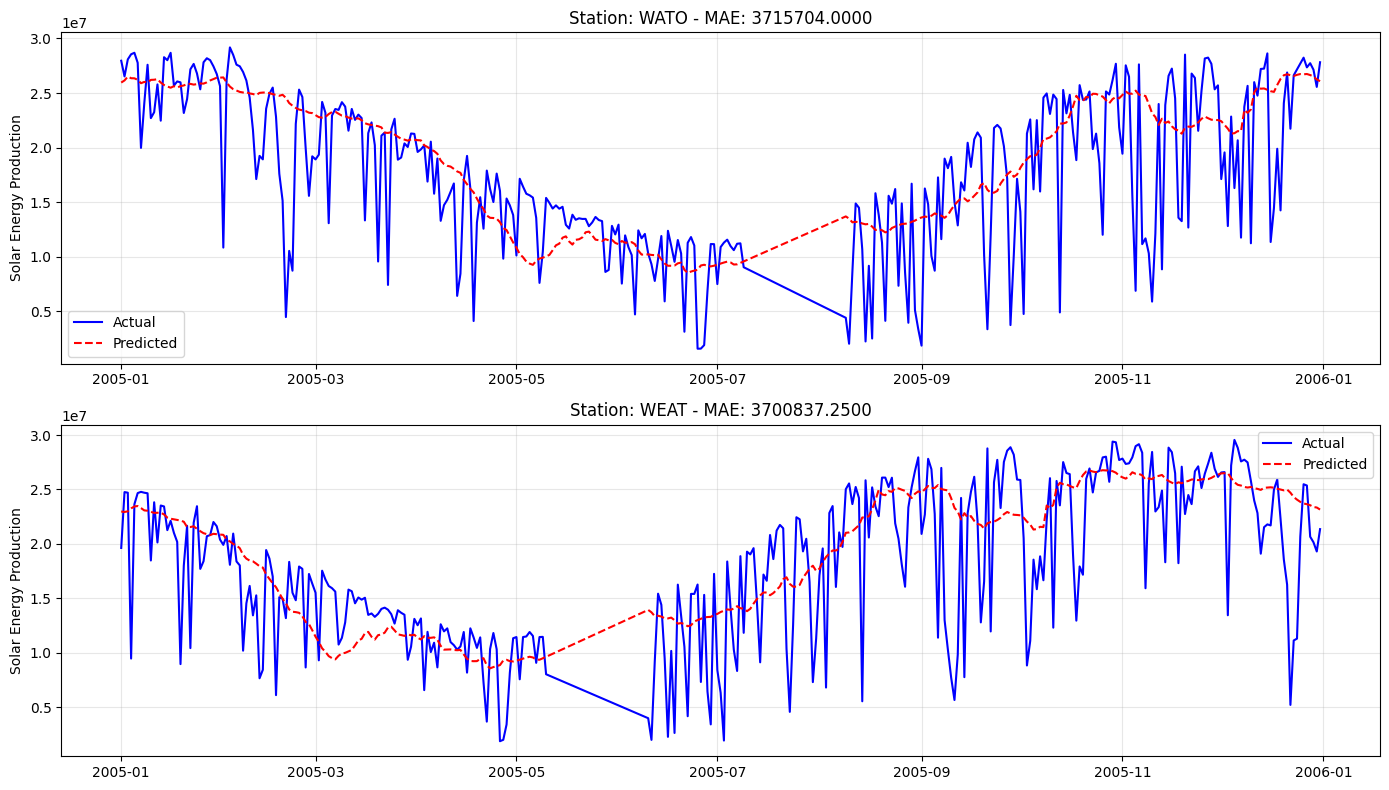

In [ ]:
# Plot best performing stations
plot_stations(df_test, station_report, "best",n=2)

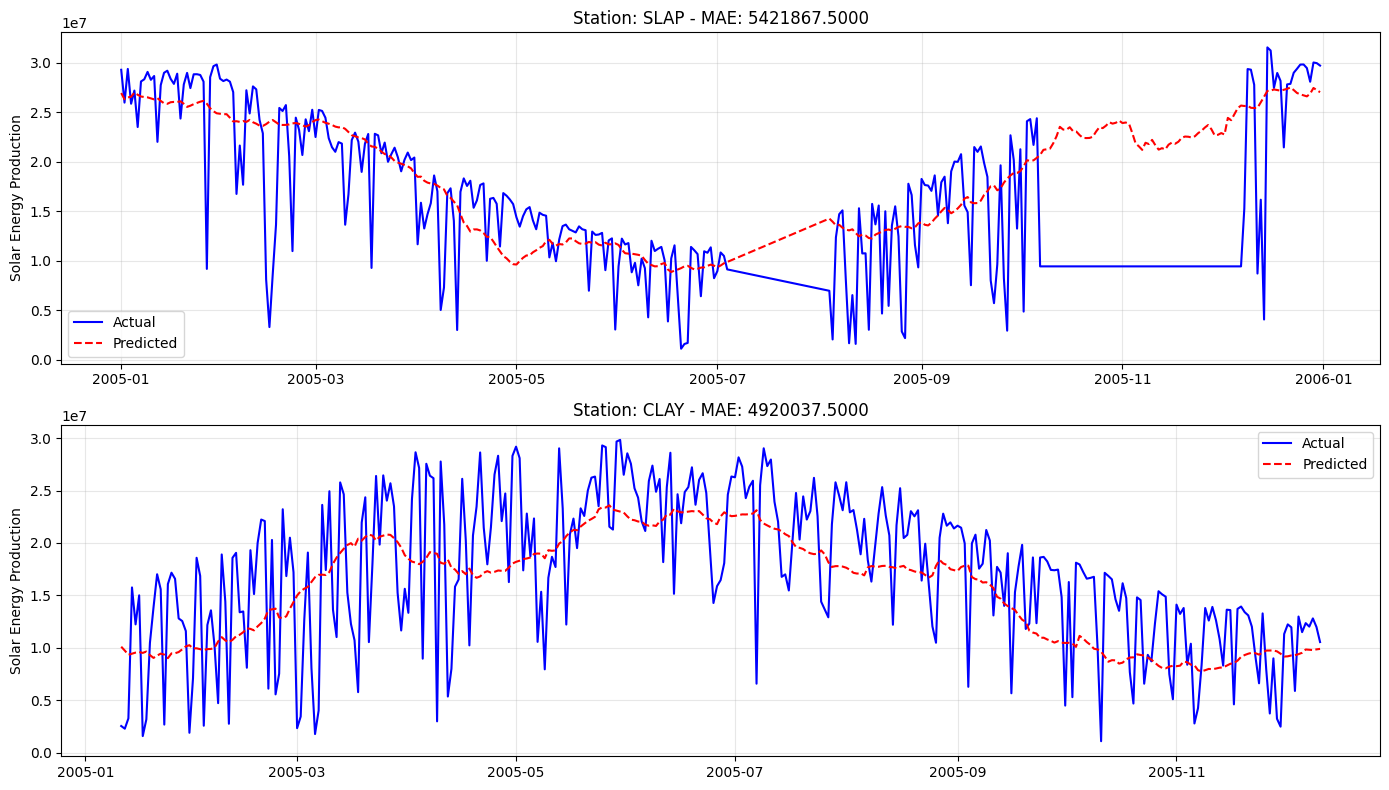

In [ ]:
# Plot best performing stations
plot_stations(df_test, station_report, "worst",n=2)

##Explainability using PGExplainer

In [ ]:
# Function to wrap the model forward pass for explainer compatibility
# This wrapper is no longer needed in this form as we pass the actual model to Explainer
# Instead, we'll create a simple wrapper class inheriting from nn.Module

class ExplainerModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, edge_index, **kwargs):
        if 'batch' in kwargs:
            return self.model(x, edge_index, kwargs['batch'])
        else:
            # If batch is not in kwargs, assume it's a single graph or the explainer
            # is handling batching differently. For a single graph, the batch vector
            # is just a tensor of zeros of size x.size(0).
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
            return self.model(x, edge_index, batch)


# Pass the actual model instance to the wrapper
wrapped_model = ExplainerModelWrapper(model)

explainer = Explainer(
    # Pass the wrapped model class instance
    model=wrapped_model,
    algorithm=PGExplainer(epochs=1, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    threshold_config=dict(threshold_type='topk', value=10),
)

import random

subset_size = 10
subset_batches = random.sample(list(train_loader), subset_size)

# Train the explainer algorithm
# Use the wrapped_model for training the explainer algorithm as well
for epoch in range(1):
    for batch in subset_batches:
        batch = batch.to(device)
        loss = explainer.algorithm.train(
            epoch,
            wrapped_model,
            batch.x,
            batch.edge_index,
            target=batch.y,
            batch=batch.batch
        )
    print(f"Explainer Training Epoch {epoch+1}, Loss: {loss:.4f}")


# Generate the explanation for a particular graph
# Ensure data is on device
test_graph_data = test_graphs[0].to(device)
explanation = explainer(test_graph_data.x, test_graph_data.edge_index, target=test_graph_data.y)

Explainer Training Epoch 1, Loss: 2289.1458


Number of unique edges in networkx: 435
Shape of edge_weights from explainer: (870,)


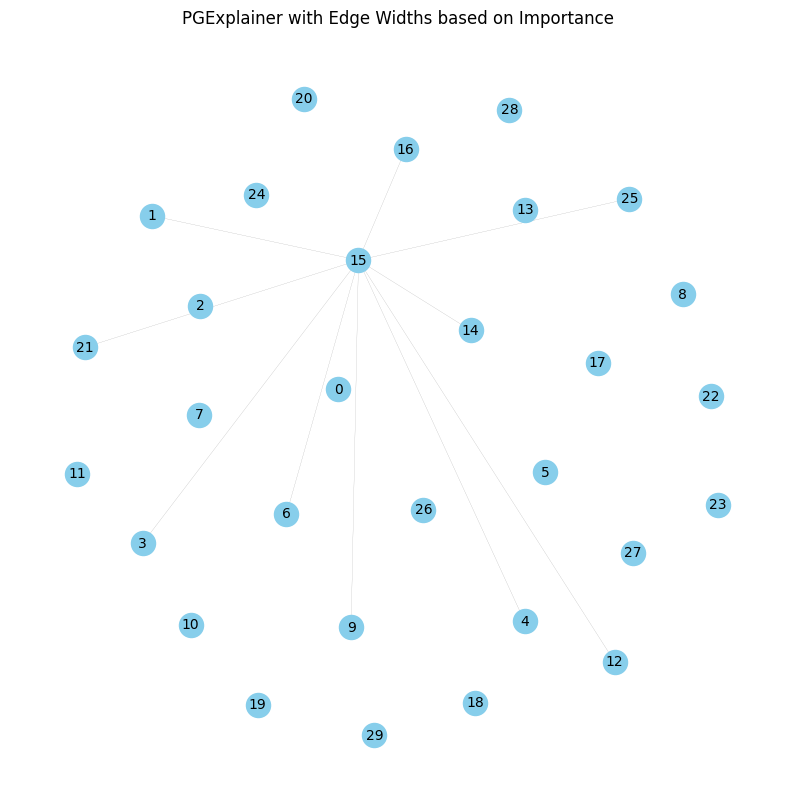

In [ ]:
import networkx as nx
import torch


edge_index = test_graph_data.edge_index.cpu().numpy()

unique_edges = set()
for i in range(edge_index.shape[1]):
    u, v = edge_index[:, i]
    # Ensure consistent order for undirected edge (u, v)
    unique_edges.add(tuple(sorted((u, v))))

G = nx.Graph()
G.add_edges_from(list(unique_edges))

pos = nx.spring_layout(G)

edge_weights = explanation.edge_mask.cpu().detach().numpy()


print(f"Number of unique edges in networkx: {G.number_of_edges()}")
print(f"Shape of edge_weights from explainer: {edge_weights.shape}")

edge_colors = ['red' if w > 0.5 else 'gray' for w in edge_weights]

# Visualizing with thicker edges for higher importance
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
# Use the edge_widths calculated from the explainer's mask
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("PGExplainer with Edge Widths based on Importance")
plt.axis('off')
plt.show()